In [124]:
import numpy as np
import pandas as pd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import itertools
import networkx as nx
import matplotlib.pyplot as plt

In [125]:
# Create the combined Bayesian Network
bn = gum.BayesNet("CombinedDepressionModel")

# -----------------------------------------
# Sociodemographic Branch
# -----------------------------------------

# Independent nodes
age = bn.add(gum.LabelizedVariable("Age", "Age category", ["Young", "Middle", "Old"]))
education = bn.add(gum.LabelizedVariable("Education", "Education Level", ["Low", "Medium", "High"]))
econ = bn.add(gum.LabelizedVariable("Income", "Income Level", ["Low", "Medium", "High"]))
bn.addArc(age, econ)
bn.addArc(education, econ)

# Aggregated SocioStatus
socio = bn.add(gum.LabelizedVariable("SocioStatus", "Overall sociodemographic status", ["High", "Medium", "Low"]))
# bn.addArc(age, socio)
bn.addArc(econ, socio)

# -----------------------------------------
# Physical Health Branch
# -----------------------------------------
chronic = bn.add(gum.LabelizedVariable("Chronic Illness", "Chronic Illness Status", ["Absent", "Present"]))
obesity = bn.add(gum.LabelizedVariable("Obesity", "Obesity Status", ["Not Obese", "Obese"]))

# Aggregated PhysicalHealth
physhealth = bn.add(gum.LabelizedVariable("PhysicalHealth", "Overall Physical Health", ["Good", "Poor"]))
bn.addArc(chronic, physhealth)
bn.addArc(obesity, physhealth)

# -----------------------------------------
# Additional Independent Nodes
# -----------------------------------------

genetic = bn.add(gum.LabelizedVariable("GeneticPredisposition", "Genetic Predisposition", ["Absent", "Present"]))
bn.cpt(genetic).fillWith([0.8, 0.2])  # 80% do not have a genetic predisposition

adverse = bn.add(gum.LabelizedVariable("AdverseChildhood", "Adverse Childhood Experiences", ["Absent", "Present"]))
bn.cpt(adverse).fillWith([0.7, 0.3])  # 70% report no ACE, 30% do

# -----------------------------------------
# Outcome Node: Depression 
# -----------------------------------------

depress = bn.add(gum.LabelizedVariable("Depression", "Depression Status", ["No", "Yes"]))
bn.addArc(socio, depress)
bn.addArc(physhealth, depress)
bn.addArc(genetic, depress)
bn.addArc(adverse, depress)


In [126]:
# -----------------------------------------
# Setting Up the CPTs for the Other Nodes
# -----------------------------------------
# Sociodemographic branch
bn.cpt(education).fillWith([0.5, 0.3, 0.2])
bn.cpt(age).fillWith([0.6, 0.3, 0.1])
# For Income (now conditioned on both Age and Education), we specify 9 rows.
cpt_econ = bn.cpt(econ)
# For Young individuals (Age = 0):
cpt_econ[{'Age': 0, 'Education': 0}] = [0.9, 0.09, 0.01]   # Low education: higher chance of low income.
cpt_econ[{'Age': 0, 'Education': 1}] = [0.80, 0.15, 0.05]   # Medium education.
cpt_econ[{'Age': 0, 'Education': 2}] = [0.70, 0.20, 0.1]   # High education: higher chance of medium/high income.
# For Middle-aged individuals (Age = 1):
cpt_econ[{'Age': 1, 'Education': 0}] = [0.80, 0.15, 0.05]   # Low education.
cpt_econ[{'Age': 1, 'Education': 1}] = [0.70, 0.20, 0.1]   # Medium education.
cpt_econ[{'Age': 1, 'Education': 2}] = [0.5, 0.3, 0.2]   # High education.
# For Old individuals (Age = 2):
cpt_econ[{'Age': 2, 'Education': 0}] = [0.70, 0.20, 0.1]    # Low education.
cpt_econ[{'Age': 2, 'Education': 1}] = [0.5, 0.3, 0.2]   # Medium education.
cpt_econ[{'Age': 2, 'Education': 2}] = [0.3, 0.4, 0.3]   # High education.

In [127]:
# # Assume that 'bn' is your Bayesian network and 'socio' is the aggregated SocioStatus node.
# # The CPT for SocioStatus has 3 outcomes (e.g., 0 = Low, 1 = Medium, 2 = High).
# cpt_socio = bn.cpt(socio)

# # --- For Age = 0 (Young) ---
# cpt_socio[{'Age': 0, 'Income': 0}] = [0.01, 0.04, 0.95]  # [High, Medium, Low]
# cpt_socio[{'Age': 0, 'Income': 1}] = [0.03, 0.07, 0.90]
# cpt_socio[{'Age': 0, 'Income': 2}] = [0.05, 0.10, 0.85]

# # --- For Age = 1 (Middle-aged) ---
# cpt_socio[{'Age': 1, 'Income': 0}] = [0.15, 0.35, 0.50]  # [High, Medium, Low]
# cpt_socio[{'Age': 1, 'Income': 1}] = [0.20, 0.40, 0.40]
# cpt_socio[{'Age': 1, 'Income': 2}] = [0.25, 0.45, 0.30]

# # --- For Age = 2 (Old) ---
# cpt_socio[{'Age': 2, 'Income': 0}] = [0.30, 0.40, 0.30]  # if symmetric, same numbers but now interpreted in the reversed order
# cpt_socio[{'Age': 2, 'Income': 1}] = [0.38, 0.40, 0.23]
# cpt_socio[{'Age': 2, 'Income': 2}] = [0.45, 0.40, 0.15]


In [128]:
# Assume that 'bn' is your Bayesian network and 'socio' is the aggregated SocioStatus node.
# Here, SocioStatus now has a CPT indexed only by Income (i.e. without Age).
cpt_socio = bn.cpt(socio)

# --- For Income = 0 ---
cpt_socio[{'Income': 0}] = [0.153, 0.263, 0.584]  # [High, Medium, Low]

# --- For Income = 1 ---
cpt_socio[{'Income': 1}] = [0.203, 0.290, 0.507]

# --- For Income = 2 ---
cpt_socio[{'Income': 2}] = [0.250, 0.317, 0.433]


In [129]:
# Physical Health branch
bn.cpt(chronic).fillWith([0.4, 0.6])
bn.cpt(obesity).fillWith([0.6, 0.4])

(pyAgrum.Potential<double>@000002A7409EA7A0) 
  Obesity          |
Not Obese|Obese    |
---------|---------|
 0.6000  | 0.4000  |

In [130]:
# Assuming 'bn' is your Bayesian network and 'physhealth' is the PhysicalHealth node
# that now has only 2 outcomes (e.g., Good and Poor)

cpt_physHealth = bn.cpt(physhealth)

# Chronic Illness: Absent (0); Obesity: Not Obese (0)
# Original: [Good: 0.95, Moderate: 0.04, Poor: 0.01]
# Remove Moderate and renormalize:
total = 0.95 + 0.01  # = 0.96
cpt_physHealth[{'Chronic Illness': 0, 'Obesity': 0}] = [0.95 / total, 0.01 / total]  # ≈ [0.9896, 0.0104]

# Chronic Illness: Absent (0); Obesity: Present (1)
# Original: [Good: 0.50, Moderate: 0.40, Poor: 0.0]
total = 0.50 + 0.0   # = 0.50
cpt_physHealth[{'Chronic Illness': 0, 'Obesity': 1}] = [0.50 / total, 0.0 / total]  # = [1.0, 0.0]

# Chronic Illness: Present (1); Obesity: Not Obese (0)
# Original: [Good: 0.30, Moderate: 0.40, Poor: 0.30]
total = 0.30 + 0.30  # = 0.60
cpt_physHealth[{'Chronic Illness': 1, 'Obesity': 0}] = [0.30 / total, 0.30 / total]  # = [0.5, 0.5]

# Chronic Illness: Present (1); Obesity: Present (1)
# Original: [Good: 0.00, Moderate: 0.20, Poor: 0.80]
total = 0.00 + 0.80  # = 0.80
cpt_physHealth[{'Chronic Illness': 1, 'Obesity': 1}] = [0.00 / total, 0.80 / total]  # = [0.0, 1.0]


In [131]:
# # Assuming 'bn' is your Bayesian network and 'physhealth' is the aggregated PhysicalHealth node.
# cpt_physHealth = bn.cpt(physhealth)

# # When Chronic Illness is Absent (0) and Obesity is Not Obese (0)
# cpt_physHealth[{'Chronic Illness': 0, 'Obesity': 0}] = [0.95, 0.04, 0.01]
# # When Chronic Illness is Absent (0) and Obesity is Present (1)
# cpt_physHealth[{'Chronic Illness': 0, 'Obesity': 1}] = [0.50, 0.40, 0.0]
# # When Chronic Illness is Present (1) and Obesity is Not Obese (0)
# cpt_physHealth[{'Chronic Illness': 1, 'Obesity': 0}] = [0.30, 0.40, 0.30]
# # When Chronic Illness is Present (1) and Obesity is Present (1)
# cpt_physHealth[{'Chronic Illness': 1, 'Obesity': 1}] = [0.00, 0.2, 0.8]

In [132]:
# --- Define risk parameters ---
# These values represent the triggering chances for each contributing factor
ss_params = {0: 0.01, 1: 0.02, 2: 0.05}     # For SocioStatus: 0 = High, 1 = Medium, 2 = Low
ph_params = {0: 0.0, 1: 0.02}      # For PhysicalHealth: 0 = Good, 1 = Moderate, 2 = Poor
ace_params = {0: 0.01, 1: 0.2}              # For ACE: 0 = Absent, 1 = Present
gp_multiplier = {0: 1.0, 1: 2}         # If GeneticPredisposition is present (state 1), multiply baseline by 2
leak = 0.01                             # A small baseline risk

# --- Retrieve and fill the CPT for Depression ---
cpt_depress = bn.cpt(depress)
cpt_values = []  # will accumulate a flat list of 72 numbers

# For each combination of parent states:
for ace_state, gp_state, ph, ss in itertools.product(range(2), range(2), range(2), range(3)):
    # Compute the baseline probability without Genetic:
    prod_failure = (1 - ss_params[ss]) * (1 - ph_params[ph]) * (1 - ace_params[ace_state]) * (1 - leak)
    p_baseline = 1 - prod_failure  # noisy-OR probability from these factors

    # genetic alone will not generate risk.
    if gp_state == 1:
        p_dep = min(1.0, p_baseline * gp_multiplier[1])
    else:
        p_dep = p_baseline

    # For a binary outcome, the CPT row is: [P(No Depression), P(Depression)]
    cpt_values.extend([1 - p_dep, p_dep])

# Use fillWith with a flat list of 72 values
cpt_depress.fillWith(cpt_values)

(pyAgrum.Potential<double>@000002A7409EC160) 
                           ||  Depression       |
SocioS|Physic|Geneti|Advers||No       |Yes      |
------|------|------|------||---------|---------|
High  |Good  |Absent|Absent|| 0.9703  | 0.0297  |
Medium|Good  |Absent|Absent|| 0.9605  | 0.0395  |
Low   |Good  |Absent|Absent|| 0.9311  | 0.0689  |
High  |Poor  |Absent|Absent|| 0.9509  | 0.0491  |
Medium|Poor  |Absent|Absent|| 0.9413  | 0.0587  |
Low   |Poor  |Absent|Absent|| 0.9125  | 0.0875  |
[...12 more line(s) ...]
High  |Good  |Presen|Presen|| 0.5682  | 0.4318  |
Medium|Good  |Presen|Presen|| 0.5523  | 0.4477  |
Low   |Good  |Presen|Presen|| 0.5048  | 0.4952  |
High  |Poor  |Presen|Presen|| 0.5368  | 0.4632  |
Medium|Poor  |Presen|Presen|| 0.5213  | 0.4787  |
Low   |Poor  |Presen|Presen|| 0.4747  | 0.5253  |

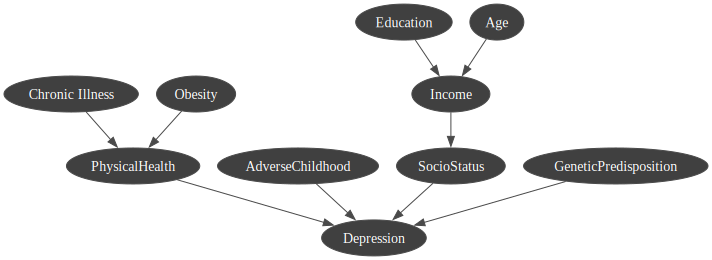

In [133]:
gnb.show(bn, size="11")  # Increase graphical scaling

In [134]:
# Iterate over all nodes in the BN and show their CPTs:
for node in bn.nodes():
    var_name = bn.variable(node).name()
    print(f"Statistics for {var_name}:")
    gnb.showPotential(bn.cpt(node))

Statistics for Age:


Statistics for Education:


Statistics for Income:


Statistics for SocioStatus:


Statistics for Chronic Illness:


Statistics for Obesity:


Statistics for PhysicalHealth:


Statistics for GeneticPredisposition:


Statistics for AdverseChildhood:


Statistics for Depression:


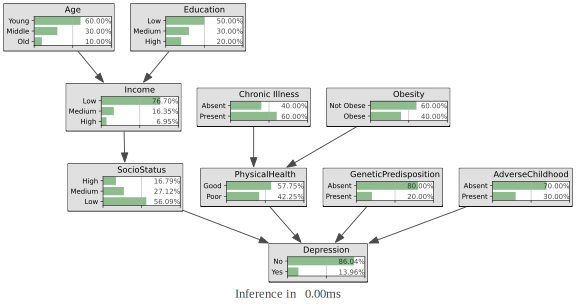

In [135]:
ie = gum.LazyPropagation(bn)
ie.setEvidence({'Age': [0.6, 0.3, 0.1]})
ie.setEvidence({'Obesity': [0.6, 0.4]})
gnb.showInference(bn)